In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader, Subset

import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# device = "cpu"

cuda


In [30]:
transform = T.Compose([T.ToTensor(), T.Normalize([.5, .5, .5], [.5, .5, .5])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
devset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

### spliting the devset into two separate sets
randidx = np.random.permutation(10_000)
devset = Subset(devset, randidx[:6000])
testset = Subset(devset, randidx[6000:])

batch_size = 32
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
dev_loader = DataLoader(devset, batch_size=batch_size)
test_loader = DataLoader(testset, batch_size=len(testset))

Files already downloaded and verified
Files already downloaded and verified


In [31]:
# check out the shape of the datasets
print('Data shapes (train/dev/test):')
print(len(trainset))
print(len(devset))
print(len(testset))

# and the range of pixel intensity values
print('\nData value range:')
print((np.min(trainset.data), np.max(trainset.data)))

# the unique categories
print('\nData categories:')
print(trainset.classes)

Data shapes (train/dev/test):
50000
6000
4000

Data value range:
(0, 255)

Data categories:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [32]:
# It looks like the images are the wrong dimensions!
# They need to be 3x32x32.
# And they are not normalized!

# but...
X, y = next(iter(train_loader))

# try again
print('Data shapes (train/test):')
print(X.data.shape)

# and the range of pixel intensity values
print('\nData value range:')
print((torch.min(X.data), torch.max(X.data)))

Data shapes (train/test):
torch.Size([32, 3, 32, 32])

Data value range:
(tensor(-1.), tensor(1.))


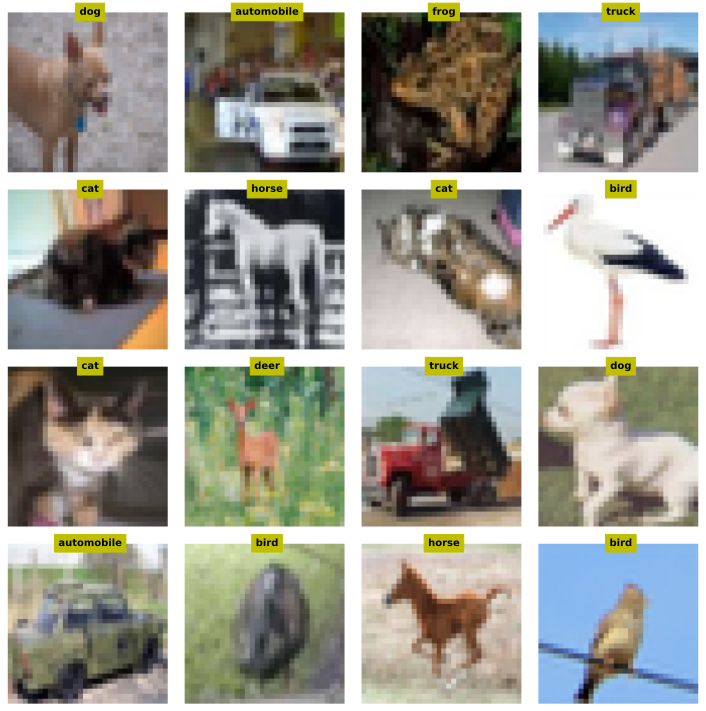

In [33]:
# inspect a few random images

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for (i, ax) in enumerate(axs.flatten()):
    # extract that image (need to transpose it back to 32x32x3)
    pic = X.data[i].numpy().transpose((1, 2, 0))
    pic = pic / 2 + .5  # undo normalization

    # and its label
    label = trainset.classes[y[i]]

    # and show!
    ax.imshow(pic)
    ax.text(16, 0, label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Create the DL model

In [34]:
def makeTheNet(printtoggle=False):
    class Net(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()

            self.print = printtoggle

            ### ---- feature map layer ---- ###
            # first conv layer
            self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(64)
            # output size = (32+2*1-3)/1 + 1 = 32/2 = 16 (bc max pool)

            # second conv layer
            self.conv2 = nn.Conv2d(64, 128, 3)
            self.bnorm2 = nn.BatchNorm2d(128)
            # output size = (16+2*0-3)/1 + 1 = 14/2 = 7 (bc max pool)
            # third convolution layer

            self.conv3 = nn.Conv2d(128, 256, 3)
            self.bnorm3 = nn.BatchNorm2d(256)  # input the number of channels in this layer
            # output size: (7+2*0-3)/1 + 1 = 5/2 = 2 (/2 b/c maxpool)
            ### ------ linear decision layer ----- ###
            self.fc1 = nn.Linear(2 * 2 * 256, 256)
            self.fc1 = nn.Linear(256, 64)
            self.fc1 = nn.Linear(64, 10)

        def forward(self, x):
            if self.print: print(f"input:{list(x.shape)}")
    
            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu(self.bnorm1(x))
            if self.print: print(f"input:{list(x.shape)}")
    
            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu(self.bnorm2(x))
            if self.print: print(f"input:{list(x.shape)}")
    
            x = F.max_pool2d(self.conv3(x), 2)
            x = F.leaky_relu(self.bnorm3(x))
            if self.print: print(f"input:{list(x.shape)}")
    
            # reshape for linear layer
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f'Vectorized: {list(x.shape)}')
    
            # linear layers
            x = F.leaky_relu(self.fc1(x))
            x = F.dropout(x, p=.5, training=self.training)
            x = F.leaky_relu(self.fc2(x))
            x = F.dropout(x, p=.5, training=self.training)  # training=self.training means to turn off during eval mode
            x = self.fc3(x)
            if self.print: print(f'Final output: {list(x.shape)}')
    
            return x
    # create the model instance


    net = Net(printtoggle)
    
    # loss function
    lossfun = nn.CrossEntropyLoss()
    
    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=1e-5)
    
    return net, lossfun, optimizer


In [35]:
# test the model with one batch
net, lossfun, optimizer = makeTheNet(True)

X, y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# now compute the loss
loss = lossfun(yHat, torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

input:[32, 3, 32, 32]
input:[32, 64, 16, 16]
input:[32, 128, 7, 7]
input:[32, 256, 2, 2]
Vectorized: [32, 1024]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1024 and 64x10)